<a href="https://colab.research.google.com/github/zares89/Cifar10-CNN/blob/main/cifar10_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

This code is mostly copied from pytorch tutorial on CNNs. First, we download CIFAR10 training and test sets.

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


We randomly show some images with their labels

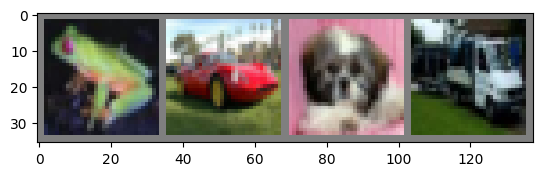

frog  car   dog   truck


In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))


We check the number of channels and pixel dimensions of the images.

In [5]:
images[0].shape

torch.Size([3, 32, 32])

We define a class copied from the Neural Network module from Pytorch. The number of input channels should be set to 3 for RGB images. 6 filters with size 5x5 is considered first (output dimensions: 32-5+1 = 28), followed by a max pooling that reduces the conv dimensions to half (6x14x14) and another convolutional layer with 16 channels with dimensions of 5 x 5 and another max pooling (output -> 16 * 5 * 5). Then, we have 3 fully connected layers (input dimension: 16x5x5, output dimension: 120). The matching number of classes and the number of neurons in the last layer are 10. The Relu activation function (0 if the input value (w*x + b) is less than zero and (w*x + b) if the input is equal or greater than 0) is chosen.

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [7]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight
print(params[1].size())  # Relu1's .weight
print(params[2].size())  # conv2's .weight
print(params[3].size())  # Relu2's .weight

10
torch.Size([6, 3, 5, 5])
torch.Size([6])
torch.Size([16, 6, 5, 5])
torch.Size([16])


In [8]:
# See how 10 input tensors transform with this network
input = torch.randn(1, 3, 32, 32)
out = net(input)
print(out)

tensor([[-0.1062,  0.0191,  0.0379,  0.1009, -0.0417,  0.0660, -0.0435, -0.0094,
         -0.0753,  0.0740]], grad_fn=<AddmmBackward0>)


Now we zero the gradient values and backprop the output

In [40]:
net.zero_grad()
out.backward(torch.randn(1, 10))

Using the Mean Square Error as the loss function, we calculate hte gradients and perform backpropogation. Later, we'll use the cross entropy and calculate the accuract of the model in the test set.

In [44]:
output = net(input)
target = torch.randn(10 ) # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)
print(target)

tensor(0.9197, grad_fn=<MseLossBackward0>)
tensor([[-0.0401, -0.0582, -0.0220,  1.6149,  1.3964,  2.1255,  0.1696,  0.0907,
         -0.1591,  0.2649]])


In [46]:
# We can follow the gradients as backpropogation is happening
print(loss.grad_fn)  # MSELoss
print(loss.grad_fn.next_functions[0][0])  # Linear
print(loss.grad_fn.next_functions[0][0].next_functions[0][0])  # ReLU

In [47]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
None
conv1.bias.grad after backward
tensor([-0.0157,  0.0100,  0.0096,  0.0044, -0.0070,  0.0137])


In [48]:
# We choose the stochastic gradient descent for optimizing the network
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

Now we use the cross entropy along with the stochastic gradient descent optimizer and train the model.

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [21]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.205
[1,  4000] loss: 1.884
[1,  6000] loss: 1.699
[1,  8000] loss: 1.602
[1, 10000] loss: 1.559
[1, 12000] loss: 1.504
[2,  2000] loss: 1.442
[2,  4000] loss: 1.377
[2,  6000] loss: 1.364
[2,  8000] loss: 1.347
[2, 10000] loss: 1.306
[2, 12000] loss: 1.297
Finished Training


In [51]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

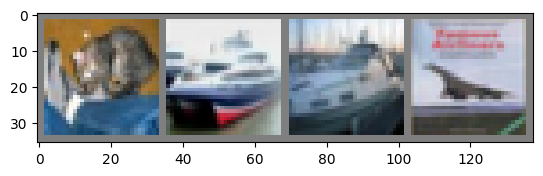

GroundTruth:  cat   ship  ship  plane


In [52]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [53]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [54]:
outputs = net(images)

In [55]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


Much better than random (10%) !!!

Running on GPU

In [12]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

net.to(device)

cuda:0


Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [16]:
# Sending the input and target to GPU
inputs, labels = data[0].to(device), data[1].to(device)

I observed a little bit of speedup. Here, I'll change the parameters for the CNNs and linear functions accordingly to see if any improvement happens. After a couple of trial and errors, I chose the first convolutional layers dimensions to 3x3 (A finer filter which can capture more details) and increased the number of filters to 10.

In [38]:
net.conv1 = nn.Conv2d(3, 10, 3) # 3x3 filters
net.pool = nn.MaxPool2d(2, 2)
net.conv2 = nn.Conv2d(10, 16, 5)
net.fc1 = nn.Linear(16 * 5 * 5, 120)
net.fc2 = nn.Linear(120, 84)
net.fc3 = nn.Linear(84, 10)

In [39]:
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

We train the model again

In [40]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.261
[1,  4000] loss: 1.908
[1,  6000] loss: 1.695
[1,  8000] loss: 1.567
[1, 10000] loss: 1.500
[1, 12000] loss: 1.447
[2,  2000] loss: 1.379
[2,  4000] loss: 1.343
[2,  6000] loss: 1.302
[2,  8000] loss: 1.298
[2, 10000] loss: 1.253
[2, 12000] loss: 1.212
Finished Training


In [41]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 57 %


The accuracy increased by 2%.